We want to the build a segmentation and clustering of the  neighborhoods of the  city of California.
The  objective  of the segmentation/Clustering is to  provide guidance  to investors or  privates who want to  buy a house  in this city.  Hence  our  aim  is to identify  neighborhood clusters  in the city  based on several  features of a given neighborhood. Some include

-	Proximity to the  ocean
-	Median income  
-	Median house value
-	Median age of houses
-	Location (longitude, latitude)
-	Number of households

The  primary group that might be   interested in the clustering of houses are  mortgage companies. The  clustering will enable to quickly find a choice that  fits a client. 
A second group for which this job is of interest is  made up of businesses such as Theater/Movies, Restaurants, Malls. Cluster  will determine which type of ressources or  products will be allocate to the  neighborhood.   
The clustering of neighborhood is also important for the  city council. Depending on the factors defining the clusters, some  neighborhoods might be rebuild or other plans developed. 






Our  dataset is the  California Housing Prices dataset  the StatLib repository. The version  we used is taken 
the  Kaggle website: https://www.kaggle.com/camnugent/california-housing-prices

The dataset is based on data from the 1990 California census. The census is conducted on several blocks. A block is
the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

The columns describing the  dataset are as follows:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea


We are going to  use the  longitude and latitude to describe  a block (neighborhood), and  determine the  top 100 venues  in the block using Foursquare location. We  will rely on the  top 5 common venues and the  other features of the  datasets to determine a clustering  of the  city. 

Below we give an overview of the dataset. 

In [804]:
#import  all libraries needed
import os
import  numpy as np
import  pandas as pd
from pandas import DataFrame
import scipy
import folium
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors


In [240]:
#Load  data
path="C:\\Users\\makou\\MachineLearning\\housing.csv"

data=pd.read_csv(path)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Choice of the population size 

In [241]:
#we only consider  neighborhood with more than 4000 inhabitants
data=data[data['population']>=4000]

In [243]:
data.shape

(586, 10)

The  median income  has been scaled and capped between 0.5 and 15.0 The  median age and the  median house value are also capped. Note that as we are interested in clustering, capping and scaling will not influence the results. 

 The  variable  ocean_proximity determined the  proximity of a neighborhood with respect to the  ocean and bay. It is a categorical variable with five values.

In [244]:
data['ocean_proximity'].value_counts()

<1H OCEAN     262
INLAND        227
NEAR OCEAN     57
NEAR BAY       40
Name: ocean_proximity, dtype: int64

### Grouping by longitude and latitude

The  longitude and  latitude were recorded to two decimal places. Hence several neighborhoods have been given the same geographical coordinates. In the sequel, we are going to group neighborhood by longitude and  latitude. To the  categorical variable ocean_proximity, we will use the  mode. 

In [446]:
data_group_long=data.groupby(['longitude','latitude'],as_index=False).mean()
e=[]    #this is a list to collect the  entry of the  categorical variable  ocean_proximity
for  z in  zip(data_group_long['longitude'],data_group_long['latitude']):
    f=data[(data['longitude']==z[0]) & (data['latitude']==z[1])].groupby('ocean_proximity').count()
    #print(f['longitude'].idxmax(axis=0))
    e.append(f['longitude'].idxmax(axis=0))
len(e)

data_group_long['ocean_proximity']=e



len(data_group_long)

575

In [447]:
data_group_long['track']=np.arange(len(data_group_long))       
data_group_long.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,track
0,-122.67,38.33,4.0,8072.0,1606.0,4323.0,1475.0,3.9518,220300.0,<1H OCEAN,0
1,-122.58,38.08,27.0,10839.0,1637.0,4406.0,1623.0,5.6150,285600.0,NEAR BAY,1
2,-122.58,38.10,22.0,11872.0,2300.0,5600.0,2200.0,4.6463,276300.0,NEAR BAY,2
3,-122.56,38.06,19.0,15622.0,2721.0,6109.0,2615.0,5.0965,295300.0,NEAR BAY,3
4,-122.56,38.09,17.0,9614.0,2123.0,4684.0,2060.0,4.1705,209800.0,NEAR BAY,4


## Get the neighborhoods with at least one  popular venue

Besides  population size, we only  chose neighborhood with at least  one  popular venue. In the  sequel, we are  going to  use 
the  foursquare API to  analyse the  venues of each neighborhood. 

### Define foursquare credentials

In [251]:
CLIENT_ID = 'O2WJSQIHK5TQ4J5K4KMLVXST2XAQ2JJN0VEU3WRQKCPKRSWG'# your Foursquare ID
CLIENT_SECRET = 'W0M4TOWS43EMGRGGUQ2XLOIUP3IDQXBLDCU5ABH1HTKKLDWG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O2WJSQIHK5TQ4J5K4KMLVXST2XAQ2JJN0VEU3WRQKCPKRSWG
CLIENT_SECRET:W0M4TOWS43EMGRGGUQ2XLOIUP3IDQXBLDCU5ABH1HTKKLDWG


In [255]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [256]:
california_venues = getNearbyVenues(names=data_group_long['track'],
                                   latitudes=data_group_long['latitude'],
                                   longitudes=data_group_long['longitude']
                                  )

In [360]:
california_venues.shape

(4135, 7)

In [365]:
#we now make a grouping of the  venues by neighborhood to obtain neighborhood with at least one popular venue

x=california_venues.groupby('Neighborhood',as_index=False).count()
x.head()
index_1=list(x['Neighborhood'])
print('List of Neighborhoods with at least one  popular venue is {}.'.format(index_1))

List of Neighborhoods with at least one  popular venue is [0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 151, 153, 154, 157, 159, 160, 162, 163, 166, 169, 171, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 196, 197, 198, 199, 200, 201, 202, 203, 206, 207, 208, 211, 214, 216, 217, 218, 219, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 248, 249, 250, 251, 252, 253, 254, 255,

we are now able to chose  only  neighborhoods with at least one popular venues

In [448]:
data_group_long=data_group_long.loc[index_1].reset_index()
features=['longitude','latitude','housing_median_age',
          'population','households','median_income','median_house_value','ocean_proximity','track']
data_group_long=data_group_long[features]
data_group_long.head()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,track
0,-122.67,38.33,4.0,4323.0,1475.0,3.9518,220300.0,<1H OCEAN,0
1,-122.58,38.08,27.0,4406.0,1623.0,5.6150,285600.0,NEAR BAY,1
2,-122.58,38.10,22.0,5600.0,2200.0,4.6463,276300.0,NEAR BAY,2
3,-122.56,38.09,17.0,4684.0,2060.0,4.1705,209800.0,NEAR BAY,4
4,-122.51,38.06,24.0,5162.0,1880.0,3.0742,118800.0,NEAR BAY,6


###  perform a onehot encoding of the variable ocean_proximity

In [454]:
#design a dummy variable for ocean proximity
ocean = pd.get_dummies(data_group_long[['ocean_proximity']], prefix="", prefix_sep="")
list(ocean.columns)

data_group_long[list(ocean.columns)]=ocean
data_group_long.head()

#delete the  column 'ocean_proximity'
data_group_long=data_group_long.drop('ocean_proximity',axis=1)
data_group_long.head()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,track,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.67,38.33,4.0,4323.0,1475.0,3.9518,220300.0,0,1,0,0,0
1,-122.58,38.08,27.0,4406.0,1623.0,5.6150,285600.0,1,0,0,1,0
2,-122.58,38.10,22.0,5600.0,2200.0,4.6463,276300.0,2,0,0,1,0
3,-122.56,38.09,17.0,4684.0,2060.0,4.1705,209800.0,4,0,0,1,0
4,-122.51,38.06,24.0,5162.0,1880.0,3.0742,118800.0,6,0,0,1,0


### Insertion of venue categories for  each neighborhood

In this  section, we   add to our data information about the  venues present in the  neighborhood. 

In [382]:
california_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,38.33,-122.67,Shangri-La,38.330536,-122.669511,Indian Restaurant
1,0,38.33,-122.67,Darling Farms,38.329323,-122.665618,Farm
2,1,38.08,-122.58,Marin College Baseball Field,38.076934,-122.582351,Baseball Field
3,2,38.10,-122.58,7-Eleven,38.100417,-122.574899,Convenience Store
4,2,38.10,-122.58,"Juan Vazquez Handyman & Construction, Inc.",38.097686,-122.582982,Construction & Landscaping


In [366]:
print('There are {} uniques categories.'.format(len(california_venues['Venue Category'].unique())))

There are 349 uniques categories.


In [386]:
#think about replacing the 'venue category' with value 'Neighborhood' by 'Neighborhood_dd'
#california_venues[california_venues['Venue Category']=='Neighborhood']['Venue Category']='Neighborhood_dd'

In [322]:
# one hot encoding
california_onehot = pd.get_dummies(california_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe: this will be necessary for grouping by neighborhood.
california_onehot['Neighborhood'] = california_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [california_onehot.columns[-1]] + list(california_onehot.columns[:-1])
california_onehot = california_onehot[fixed_columns]

california_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,...,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. This gives us the  distribution of venue categories  for each neighborhood. 

In [324]:
california_grouped =california_onehot.groupby('Neighborhood').mean().reset_index()
california_grouped.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,...,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now paste the distribution of venue categories with our final data. Note we need to omit the column 'Neighborhood' since
it is identical to the column 'track' with our final data. 

In [458]:
#wrong columns inserted
add_columns=list(california_grouped.drop('Neighborhood',axis=1))

data_group_long[add_columns]=california_grouped[add_columns]

data_group_long.head()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,track,<1H OCEAN,INLAND,...,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,-122.67,38.33,4.0,4323.0,1475.0,3.9518,220300.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-122.58,38.08,27.0,4406.0,1623.0,5.6150,285600.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-122.58,38.10,22.0,5600.0,2200.0,4.6463,276300.0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-122.56,38.09,17.0,4684.0,2060.0,4.1705,209800.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-122.51,38.06,24.0,5162.0,1880.0,3.0742,118800.0,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Examining the most popular  venues in every neighborhoods

In [505]:
california_grouped.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,...,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [542]:
# this function sort the  venues in  descending order according frequency occurences


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



In [543]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = california_grouped['Neighborhood']

for ind in np.arange(california_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(california_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Farm,Indian Restaurant,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store
1,1,Baseball Field,Zoo Exhibit,Garden Center,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market
2,2,Park,Convenience Store,Construction & Landscaping,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
3,4,Fast Food Restaurant,Mexican Restaurant,Nail Salon,Shoe Store,Bakery,Paper / Office Supplies Store,Clothing Store,Coffee Shop,Lake,Kids Store
4,6,History Museum,Trail,American Restaurant,Tea Room,Zoo Exhibit,Fishing Store,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


##  Create a map of California with  neighborhoods superimposed on top 

In [390]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [391]:
#First we get the coordinates of California to  center our map around it. 
address = 'California City, Ca'

geolocator = Nominatim(user_agent="california_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of California City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of California City are 35.125801, -117.9859038.


In [799]:
map_california = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng in zip(data_group_long['latitude'], data_group_long['longitude']):
    #label = '{}, {}'.format(neighborhood, borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_california)  
    
map_california

Here  we  make a scatter plot of the  locations together with the  housing prices. 
The radius of each circle represents the location population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

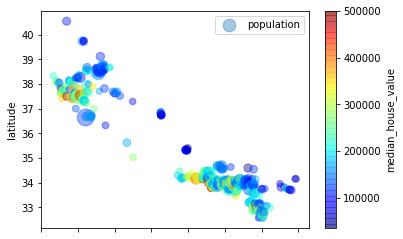

In [395]:
%matplotlib inline
import matplotlib.pyplot as plt

data_group_long.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                    s=data_group_long["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)              
plt.legend()

#  Clustering of the  neighborhoods. Neighborhood segmentation using kmeans


In [468]:
import random 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler ,MinMaxScaler

In [723]:
data_group_long.head()
# we drop some features 
columns_cluster=['housing_median_age',
                 'population','households','median_income','median_house_value','<1H OCEAN','INLAND','NEAR BAY','NEAR OCEAN']

p=california_venues.groupby('Neighborhood',as_index=False).count()

data_kmeans=data_group_long[columns_cluster]
data_kmeans['Num Venues']=p['Venue']
data_kmeans

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,housing_median_age,population,households,median_income,median_house_value,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,Num Venues
0,4.0,4323.0,1475.0,3.9518,220300.0,1,0,0,0,2
1,27.0,4406.0,1623.0,5.6150,285600.0,0,0,1,0,1
2,22.0,5600.0,2200.0,4.6463,276300.0,0,0,1,0,3
3,17.0,4684.0,2060.0,4.1705,209800.0,0,0,1,0,21
4,24.0,5162.0,1880.0,3.0742,118800.0,0,0,1,0,4
5,25.0,5917.0,1812.0,2.7273,187500.0,0,0,1,0,4
6,27.0,5023.0,1605.0,4.6452,236200.0,0,0,0,1,21
7,45.0,4715.0,1165.0,3.4051,500001.0,0,0,1,0,13
8,16.0,5130.0,1574.0,4.8096,262000.0,0,0,0,1,4
9,16.0,4375.0,1231.0,5.1788,267000.0,0,0,0,1,3


In [683]:
data_kmeans=StandardScaler().fit_transform(data_kmeans.values)

In [687]:
data_kmeans

array([[-1.27906915, -0.6916327 , -0.56616347, ..., -0.2850686 ,
        -0.30595311, -0.5522285 ],
       [ 1.26781849, -0.65016369, -0.37056827, ...,  3.50792753,
        -0.30595311, -0.63548864],
       [ 0.71414726, -0.05360955,  0.39198868, ...,  3.50792753,
        -0.30595311, -0.46896837],
       ...,
       [-0.50392943, -0.01264017, -0.83312448, ..., -0.2850686 ,
        -0.30595311, -0.21918796],
       [-0.28246094, -0.77007407, -0.55691234, ..., -0.2850686 ,
        -0.30595311, -0.5522285 ],
       [-0.06099245, -0.59970141, -0.12739586, ..., -0.2850686 ,
        -0.30595311, -0.38570823]])

### Identify the  best number of clusters using the  elbow approach

[2, 7, 6, 4, 14, 8, 10, 15, 7, 24, 11, 11, 9, 21, 9, 10, 15, 17, 9, 17, 9, 7, 17, 11, 14, 10, 15, 20, 13, 14, 8, 15, 15, 6, 12, 9, 12, 11, 9, 13, 7, 11, 8, 8, 11, 11, 7, 9, 11, 14, 11, 15, 7, 8, 13, 14, 12, 8, 10, 12, 11, 9, 7, 8, 8, 16, 8, 9, 7, 8, 8, 9, 19, 6, 8, 7, 10, 10, 8, 14, 6, 6, 8, 9, 5, 9, 9, 6, 8, 7, 6, 13, 6, 12, 8, 8, 9, 6, 7]


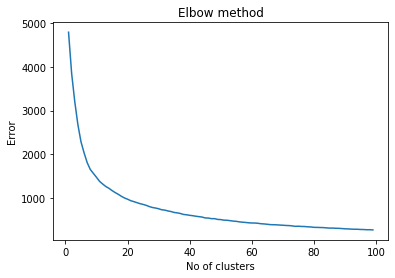

In [690]:
clusterNum = np.arange(1,100)
Error=[]
num_iter=[]
for  i in clusterNum:
    k_means = KMeans(init = "k-means++", n_clusters = i, n_init = 150)
    k_means.fit(data_kmeans)
    Error.append(k_means.inertia_)
    num_iter.append(k_means.n_iter_)
    
print(num_iter)    
Error



#plot of the number of clusters vs  error 

plt.plot(clusterNum, Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()




In [706]:
#Error

Run kmeans to cluster the  neighborhood into 5 clusters.

In [773]:
clusterNum=5



# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 150).fit(data_kmeans)
kmeans.labels_[0:12]

array([0, 0, 0, 0, 1, 3, 0, 2, 0, 0, 4, 4])

In [774]:
kmeans.labels_

array([0, 0, 0, 0, 1, 3, 0, 2, 0, 0, 4, 4, 4, 0, 3, 0, 2, 1, 0, 1, 3, 1,
       4, 0, 3, 0, 0, 0, 4, 0, 4, 4, 3, 3, 4, 3, 0, 4, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 3, 3, 0, 4, 4, 1, 2, 0, 3, 0, 3, 0,
       4, 1, 3, 1, 0, 0, 1, 0, 3, 4, 3, 0, 3, 3, 1, 3, 3, 1, 0, 0, 3, 0,
       0, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 4, 0, 0, 1, 1, 1, 1, 1, 1, 3,
       1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 3,
       0, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 4, 1, 1, 1, 0, 4, 4, 4, 4,
       4, 4, 0, 2, 0, 0, 0, 0, 0, 3, 3, 3, 4, 0, 0, 0, 3, 0, 0, 0, 0, 2,
       0, 0, 3, 0, 3, 3, 3, 3, 1, 3, 2, 0, 0, 3, 3, 3, 2, 2, 0, 0, 4, 4,
       4, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 4, 0, 0, 4, 0, 4, 0, 1, 3, 3,
       3, 0, 3, 3, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 4, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3,
       0, 3, 0, 3, 3, 3, 3, 3, 4, 3, 0, 3, 3, 3, 4,

### Assign cluster  label  to each neighborhood

In [775]:
neighborhoods_venues_sorted=neighborhoods_venues_sorted.drop('Cluster Labels',1)
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

In [776]:
data_exam=data_group_long[['track']+columns_cluster]
data_exam['Num Venues']=p['Venue']



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [777]:
data_exam.head()
data_exam.insert(1,'Cluster Labels',kmeans.labels_)

In [749]:
data_exam.head()
neighborhoods_venues_sorted.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,1,Farm,Indian Restaurant,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store
1,1,6,Baseball Field,Zoo Exhibit,Garden Center,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market
2,2,6,Park,Convenience Store,Construction & Landscaping,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
3,4,6,Fast Food Restaurant,Mexican Restaurant,Nail Salon,Shoe Store,Bakery,Paper / Office Supplies Store,Clothing Store,Coffee Shop,Lake,Kids Store
4,6,6,History Museum,Trail,American Restaurant,Tea Room,Zoo Exhibit,Fishing Store,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


## Examination of the  clusters

# Cluster 1:

In [823]:
data_exam[data_exam['Cluster Labels']==0].describe().drop('track',axis=1).T


,count,mean,std,min,25%,50%,75%,max
Cluster Labels,122.0,0.000000,0.000000,0.000,0.00000,0.00000,0.000000,0.000
housing_median_age,122.0,15.143443,8.820403,2.000,7.00000,15.00000,21.000000,52.000
population,122.0,5826.450820,1801.706316,4014.000,4483.75000,4980.50000,7175.500000,13251.000
households,122.0,2066.885246,728.158134,962.000,1559.00000,1854.50000,2416.500000,4855.000
median_income,122.0,4.757689,1.237185,1.724,3.82415,4.95465,5.672625,6.992
median_house_value,122.0,244891.393443,23864.878489,209800.000,225000.00000,239750.00000,263900.000000,290500.000
<1H OCEAN,122.0,0.606557,0.490528,0.000,0.00000,1.00000,1.000000,1.000
INLAND,122.0,0.155738,0.364102,0.000,0.00000,0.00000,0.000000,1.000
NEAR BAY,122.0,0.163934,0.371743,0.000,0.00000,0.00000,0.000000,1.000
NEAR OCEAN,122.0,0.073770,0.262475,0.000,0.00000,0.00000,0.000000,1.000


In [825]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==0].T

,0,1,2,3,6,8,9,13,15,18,...,433,434,436,438,450,457,460,463,467,471
Neighborhood,0,1,2,4,8,11,12,16,18,21,...,520,521,526,528,541,548,553,556,560,565
Cluster Labels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st Most Common Venue,Farm,Baseball Field,Park,Fast Food Restaurant,Restaurant,Park,Grocery Store,Hotel,Park,BBQ Joint,...,Park,Athletics & Sports,Business Service,Food,Thrift / Vintage Store,Fast Food Restaurant,Soccer Field,Golf Course,Park,Hotel
2nd Most Common Venue,Indian Restaurant,Zoo Exhibit,Convenience Store,Mexican Restaurant,Snack Place,Hostel,Filipino Restaurant,Cocktail Bar,Island,Zoo Exhibit,...,Flower Shop,Zoo Exhibit,Zoo Exhibit,Juice Bar,Pub,Coffee Shop,Plaza,Bar,Trail,Fast Food Restaurant
3rd Most Common Venue,Flower Shop,Garden Center,Construction & Landscaping,Nail Salon,Sushi Restaurant,Burmese Restaurant,Park,Boutique,Beach,Farm,...,Farmers Market,Farm,Fast Food Restaurant,Athletics & Sports,Scenic Lookout,Grocery Store,Flower Shop,Scenic Lookout,Resort,ATM
4th Most Common Venue,Farmers Market,Fast Food Restaurant,Flower Shop,Shoe Store,Chinese Restaurant,Dessert Shop,Fried Chicken Joint,Art Gallery,Tunnel,Fast Food Restaurant,...,Fast Food Restaurant,Fast Food Restaurant,Filipino Restaurant,Art Gallery,Flea Market,Breakfast Spot,Farmers Market,Night Market,Home Service,Playground
5th Most Common Venue,Fast Food Restaurant,Filipino Restaurant,Farmers Market,Bakery,Sandwich Place,Farmers Market,Flea Market,Café,Zoo Exhibit,Filipino Restaurant,...,Filipino Restaurant,Filipino Restaurant,Fish & Chips Shop,Zoo Exhibit,Farm,Shopping Plaza,Fast Food Restaurant,Lake,Fishing Spot,Sushi Restaurant
6th Most Common Venue,Filipino Restaurant,Fish & Chips Shop,Fast Food Restaurant,Paper / Office Supplies Store,Sporting Goods Shop,Fast Food Restaurant,Farmers Market,Italian Restaurant,Flea Market,Fish & Chips Shop,...,Fish & Chips Shop,Fish & Chips Shop,Fish Market,Fast Food Restaurant,Farmers Market,Sandwich Place,Filipino Restaurant,Flea Market,Exhibit,Burger Joint
7th Most Common Venue,Fish & Chips Shop,Fish Market,Filipino Restaurant,Clothing Store,Bowling Alley,Filipino Restaurant,Fast Food Restaurant,Gym / Fitness Center,Fast Food Restaurant,Fish Market,...,Fish Market,Fish Market,Fishing Spot,Filipino Restaurant,Fast Food Restaurant,ATM,Fish & Chips Shop,Farmers Market,Farm,Business Service
8th Most Common Venue,Fish Market,Fishing Spot,Fish & Chips Shop,Coffee Shop,Café,Fish & Chips Shop,Frozen Yogurt Shop,Church,Filipino Restaurant,Fishing Spot,...,Fishing Spot,Fishing Spot,Fishing Store,Fish & Chips Shop,Filipino Restaurant,Department Store,Fish Market,Fast Food Restaurant,Farmers Market,Sandwich Place


# Cluster 2 


In [827]:
data_exam[data_exam['Cluster Labels']==1].describe().drop('track',1).T


,count,mean,std,min,25%,50%,75%,max
Cluster Labels,114.0,1.000000,0.000000,1.0000,1.000000,1.000000,1.000000,1.0000
housing_median_age,114.0,15.381579,7.940961,4.0000,10.000000,15.000000,19.000000,43.0000
population,114.0,5715.657895,2574.103492,4002.0000,4559.250000,5033.000000,6116.750000,28566.0000
households,114.0,1859.057018,756.686956,348.0000,1431.250000,1691.500000,2114.250000,6082.0000
median_income,114.0,2.917262,0.826155,1.2065,2.317675,2.805525,3.597525,5.0012
median_house_value,114.0,108519.736842,24108.948526,35000.0000,90525.000000,114400.000000,129525.000000,139800.0000
<1H OCEAN,114.0,0.157895,0.366252,0.0000,0.000000,0.000000,0.000000,1.0000
INLAND,114.0,0.780702,0.415598,0.0000,1.000000,1.000000,1.000000,1.0000
NEAR BAY,114.0,0.035088,0.184814,0.0000,0.000000,0.000000,0.000000,1.0000
NEAR OCEAN,114.0,0.026316,0.160779,0.0000,0.000000,0.000000,0.000000,1.0000


In [828]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==1].T

,4,17,19,21,38,39,40,46,50,59,...,464,468,469,470,472,474,475,476,477,478
Neighborhood,6,20,23,25,43,44,45,52,56,67,...,557,562,563,564,566,568,569,570,572,573
Cluster Labels,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1st Most Common Venue,History Museum,Lighting Store,Theme Park Ride / Attraction,Food,Park,Pizza Place,Bus Station,Chinese Restaurant,Intersection,Convenience Store,...,Pharmacy,Mexican Restaurant,Home Service,Video Store,Hotel Pool,Fast Food Restaurant,Bar,Buffet,Art Gallery,Tourist Information Center
2nd Most Common Venue,Trail,Zoo Exhibit,Zoo,Bus Stop,Recreation Center,Pool,Food Truck,Japanese Restaurant,Food Truck,Video Store,...,Bar,Pizza Place,Zoo Exhibit,Music Venue,Hotel,Furniture / Home Store,Butcher,Grocery Store,Dessert Shop,Burger Joint
3rd Most Common Venue,American Restaurant,Farm,Exhibit,Chinese Restaurant,Electronics Store,Plaza,Trail,Sushi Restaurant,Playground,Automotive Shop,...,Fast Food Restaurant,Asian Restaurant,Exhibit,Carpet Store,Park,American Restaurant,Deli / Bodega,Cosmetics Shop,Food & Drink Shop,Asian Restaurant
4th Most Common Venue,Tea Room,Fast Food Restaurant,Dance Studio,Gun Range,Auto Workshop,Flower Shop,Coffee Shop,Sandwich Place,Theme Park,Gym / Fitness Center,...,Spa,Fried Chicken Joint,Farmers Market,Construction & Landscaping,Lake,Chinese Restaurant,Chinese Restaurant,Juice Bar,Fast Food Restaurant,Liquor Store
5th Most Common Venue,Zoo Exhibit,Filipino Restaurant,Farm,Coffee Shop,Home Service,Farmers Market,Restaurant,Donut Shop,Photography Studio,Bowling Alley,...,Mexican Restaurant,Discount Store,Fast Food Restaurant,Convenience Store,Zoo Exhibit,Shop & Service,Shopping Mall,Clothing Store,Filipino Restaurant,Zoo Exhibit
6th Most Common Venue,Fishing Store,Fish & Chips Shop,Fast Food Restaurant,Stadium,Baseball Field,Fast Food Restaurant,Fast Food Restaurant,Pizza Place,Zoo Exhibit,Liquor Store,...,Zoo Exhibit,Other Repair Shop,Filipino Restaurant,Bar,Flea Market,Mexican Restaurant,Filipino Restaurant,Coffee Shop,Fish & Chips Shop,Flea Market
7th Most Common Venue,Farmers Market,Fish Market,Filipino Restaurant,Food Truck,Food Truck,Filipino Restaurant,Electronics Store,Fried Chicken Joint,Fishing Store,Fried Chicken Joint,...,Filipino Restaurant,Bank,Fish & Chips Shop,Department Store,Farm,Business Service,Fish & Chips Shop,Filipino Restaurant,Fish Market,Farmers Market
8th Most Common Venue,Fast Food Restaurant,Fishing Spot,Fish & Chips Shop,Flea Market,Fish Market,Fish & Chips Shop,Café,Convenience Store,Farm,Fountain,...,Fish & Chips Shop,Grocery Store,Fish Market,Flea Market,Farmers Market,Juice Bar,Fish Market,Fish & Chips Shop,Fishing Spot,Fast Food Restaurant


# cluster 3

In [830]:
data_exam[data_exam['Cluster Labels']==2].describe().drop('track',1).T


,count,mean,std,min,25%,50%,75%,max
Cluster Labels,10.0,2.00000,0.000000,2.0000,2.00000,2.00000,2.0000,2.0000
housing_median_age,10.0,20.00000,12.373807,4.0000,10.00000,20.50000,22.7500,45.0000
population,10.0,5907.10000,2444.188866,4076.0000,4525.75000,5083.50000,6102.7500,12203.0000
households,10.0,2269.15000,1217.958630,1165.0000,1606.00000,1791.25000,2682.7500,4930.0000
median_income,10.0,6.80733,2.008536,3.4051,5.36715,7.48865,8.3193,9.1232
median_house_value,10.0,473915.45000,29347.618051,415300.0000,453112.62500,481600.00000,500001.0000,500001.0000
<1H OCEAN,10.0,0.50000,0.527046,0.0000,0.00000,0.50000,1.0000,1.0000
INLAND,10.0,0.00000,0.000000,0.0000,0.00000,0.00000,0.0000,0.0000
NEAR BAY,10.0,0.10000,0.316228,0.0000,0.00000,0.00000,0.0000,1.0000
NEAR OCEAN,10.0,0.40000,0.516398,0.0000,0.00000,0.00000,1.0000,1.0000


In [831]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==2].T

,7,16,60,179,197,208,214,215,340,431
Neighborhood,9,19,68,223,243,256,263,264,399,516
Cluster Labels,2,2,2,2,2,2,2,2,2,2
1st Most Common Venue,Fishing Spot,Park,Coffee Shop,Park,Mobile Phone Shop,Harbor / Marina,Theater,Spa,Bank,Pool
2nd Most Common Venue,Scenic Lookout,Trail,Gym,Flower Shop,Yoga Studio,Boat or Ferry,Park,Gym,Japanese Restaurant,Arcade
3rd Most Common Venue,Trail,Athletics & Sports,Park,Farmers Market,Sushi Restaurant,Pizza Place,Fast Food Restaurant,Nightlife Spot,Sandwich Place,Zoo Exhibit
4th Most Common Venue,Gift Shop,Flea Market,Church,Fast Food Restaurant,Bank,Spa,Trail,Zoo Exhibit,Coffee Shop,Flower Shop
5th Most Common Venue,Tourist Information Center,Farmers Market,Optical Shop,Filipino Restaurant,Chinese Restaurant,Coffee Shop,Performing Arts Venue,Flea Market,Restaurant,Farmers Market
6th Most Common Venue,Park,Fast Food Restaurant,Flower Shop,Fish & Chips Shop,Japanese Restaurant,Beach,Shopping Mall,Farmers Market,Mobile Phone Shop,Fast Food Restaurant
7th Most Common Venue,Beach,Filipino Restaurant,Sandwich Place,Fish Market,Sandwich Place,ATM,Video Store,Fast Food Restaurant,Juice Bar,Filipino Restaurant
8th Most Common Venue,Historic Site,Fish & Chips Shop,Art Gallery,Fishing Spot,Frozen Yogurt Shop,Burger Joint,Carpet Store,Filipino Restaurant,Pizza Place,Fish & Chips Shop


# Cluster 4

In [832]:
data_exam[data_exam['Cluster Labels']==3].describe().drop('track',1).T


,count,mean,std,min,25%,50%,75%,max
Cluster Labels,187.0,3.000000,0.000000,3.0000,3.00000,3.0000,3.0000,3.0000
housing_median_age,187.0,16.015152,9.626535,2.0000,7.00000,16.0000,23.0000,47.0000
population,187.0,5574.563280,1680.634965,4010.0000,4452.50000,5008.0000,6123.0000,16305.0000
households,187.0,1757.674688,718.053191,275.0000,1297.50000,1581.0000,1964.5000,5358.0000
median_income,187.0,3.675156,1.056732,1.4133,2.82755,3.6348,4.5426,6.4865
median_house_value,187.0,171790.196078,18569.840292,140800.0000,156650.00000,170700.0000,187500.0000,208000.0000
<1H OCEAN,187.0,0.556150,0.498171,0.0000,0.00000,1.0000,1.0000,1.0000
INLAND,187.0,0.336898,0.473919,0.0000,0.00000,0.0000,1.0000,1.0000
NEAR BAY,187.0,0.037433,0.190330,0.0000,0.00000,0.0000,0.0000,1.0000
NEAR OCEAN,187.0,0.069519,0.255017,0.0000,0.00000,0.0000,0.0000,1.0000


In [833]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==3].T

,5,14,20,24,32,33,35,51,54,55,...,447,453,454,455,456,458,461,465,466,473
Neighborhood,7,17,24,28,36,37,40,57,60,62,...,537,544,545,546,547,549,554,558,559,567
Cluster Labels,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1st Most Common Venue,Park,Coffee Shop,Farm,Park,Food Truck,Fast Food Restaurant,Chinese Restaurant,Snack Place,Park,Park,...,Ice Cream Shop,Pool,Pool,Construction & Landscaping,Deli / Bodega,Brewery,Flower Shop,Tree,Hardware Store,Coffee Shop
2nd Most Common Venue,Harbor / Marina,Park,Music Venue,Theater,Coffee Shop,Chinese Restaurant,Zoo Exhibit,Park,Electronics Store,Flower Shop,...,Zoo Exhibit,Child Care Service,Jewelry Store,Zoo Exhibit,Food Truck,Movie Theater,Trail,Pet Store,Baseball Field,Zoo Exhibit
3rd Most Common Venue,Farm,Motorcycle Shop,Baseball Field,Home Service,Fast Food Restaurant,Intersection,Exhibit,Nightlife Spot,Exhibit,Farmers Market,...,Flower Shop,Football Stadium,Zoo Exhibit,Flower Shop,Tree,Home Service,Exhibit,Zoo Exhibit,Pet Store,Exhibit
4th Most Common Venue,Farmers Market,Bookstore,Flower Shop,Fishing Store,Soup Place,ATM,Farmers Market,Farm,Farmers Market,Fast Food Restaurant,...,Farmers Market,Trail,Flower Shop,Farmers Market,Zoo Exhibit,Flea Market,Farmers Market,Fishing Store,Coffee Shop,Farmers Market
5th Most Common Venue,Fast Food Restaurant,Zoo Exhibit,Fast Food Restaurant,Farm,Gym,Pharmacy,Fast Food Restaurant,Fast Food Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Fast Food Restaurant,Zoo Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Fast Food Restaurant,Farm,Hotel,Fast Food Restaurant
6th Most Common Venue,Filipino Restaurant,Filipino Restaurant,Filipino Restaurant,Farmers Market,Grocery Store,Grocery Store,Filipino Restaurant,Filipino Restaurant,Filipino Restaurant,Fish & Chips Shop,...,Filipino Restaurant,Fishing Store,Fast Food Restaurant,Filipino Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Farmers Market,Fishing Store,Filipino Restaurant
7th Most Common Venue,Fish & Chips Shop,Fish & Chips Shop,Fish & Chips Shop,Fast Food Restaurant,Big Box Store,Tennis Court,Fish & Chips Shop,Fish & Chips Shop,Fish & Chips Shop,Fish Market,...,Fish & Chips Shop,Farmers Market,Filipino Restaurant,Fish & Chips Shop,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fish & Chips Shop
8th Most Common Venue,Fish Market,Fish Market,Fish Market,Filipino Restaurant,Taco Place,Liquor Store,Fish Market,Fish Market,Fish Market,Fishing Spot,...,Fish Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Filipino Restaurant,Fish & Chips Shop,Fish Market,Filipino Restaurant,Fast Food Restaurant,Fish Market


# cluster 5

In [834]:
data_exam[data_exam['Cluster Labels']==4].describe().drop('track',1).T


,count,mean,std,min,25%,50%,75%,max
Cluster Labels,46.0,4.000000,0.000000,4.0000,4.00000,4.00000,4.00000,4.0000
housing_median_age,46.0,14.195652,8.898488,3.0000,6.00000,13.00000,21.00000,40.0000
population,46.0,5866.739130,2063.488475,4005.0000,4304.25000,5002.00000,6851.50000,12873.0000
households,46.0,2092.554348,755.696016,950.0000,1504.25000,1947.00000,2521.00000,4012.0000
median_income,46.0,5.700546,1.570974,1.6903,4.91825,6.12045,6.60945,8.3931
median_house_value,46.0,338433.695652,28986.050389,293900.0000,315325.00000,331900.00000,357375.00000,402500.0000
<1H OCEAN,46.0,0.521739,0.505047,0.0000,0.00000,1.00000,1.00000,1.0000
INLAND,46.0,0.130435,0.340503,0.0000,0.00000,0.00000,0.00000,1.0000
NEAR BAY,46.0,0.086957,0.284885,0.0000,0.00000,0.00000,0.00000,1.0000
NEAR OCEAN,46.0,0.260870,0.443961,0.0000,0.00000,0.00000,0.75000,1.0000


In [835]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==4].T

,10,11,12,22,28,30,31,34,37,57,...,339,349,354,359,368,408,418,437,446,448
Neighborhood,13,14,15,26,32,34,35,38,42,64,...,397,414,419,424,433,486,499,527,536,538
Cluster Labels,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1st Most Common Venue,Hotel,Intersection,Spa,Hotel,Fountain,Trail,Doctor's Office,Trail,Park,Baseball Field,...,Shop & Service,Theater,Lawyer,Health Food Store,Other Repair Shop,Gym Pool,Park,Baseball Field,Trail,Construction & Landscaping
2nd Most Common Venue,RV Park,Scenic Lookout,Comedy Club,Fried Chicken Joint,Sculpture Garden,Resort,Japanese Restaurant,Medical School,Intersection,Park,...,Pool,Pool,Zoo Exhibit,Home Service,Coffee Shop,Home Service,Business Service,Park,Dog Run,Zoo Exhibit
3rd Most Common Venue,Diner,Gym / Fitness Center,Thai Restaurant,Convenience Store,Coffee Shop,Zoo Exhibit,Park,Zoo Exhibit,Construction & Landscaping,Notary,...,Zoo Exhibit,Gym,Farm,Fast Food Restaurant,Athletics & Sports,Bakery,Dog Run,Recreation Center,Zoo Exhibit,Flower Shop
4th Most Common Venue,Food,Water Park,Filipino Restaurant,Mexican Restaurant,College Cafeteria,Flea Market,Mattress Store,Flea Market,Trail,Farm,...,Flea Market,Snack Place,Fast Food Restaurant,Dive Bar,Gym,Zoo Exhibit,Fast Food Restaurant,Music Venue,Flea Market,Farmers Market
5th Most Common Venue,Fast Food Restaurant,Zoo Exhibit,Bakery,Fast Food Restaurant,Monument / Landmark,Farm,Tailor Shop,Farmers Market,Flea Market,Farmers Market,...,Farmers Market,Zoo Exhibit,Filipino Restaurant,Furniture / Home Store,Art Gallery,Flea Market,Filipino Restaurant,Gym,Farmers Market,Fast Food Restaurant
6th Most Common Venue,Filipino Restaurant,Flea Market,Martial Arts Dojo,Furniture / Home Store,Café,Farmers Market,Sushi Restaurant,Fast Food Restaurant,Farm,Fast Food Restaurant,...,Fast Food Restaurant,Fishing Store,Fish & Chips Shop,Fishing Spot,Zoo Exhibit,Farmers Market,Fish & Chips Shop,Athletics & Sports,Fast Food Restaurant,Filipino Restaurant
7th Most Common Venue,Fish & Chips Shop,Farmers Market,Thrift / Vintage Store,Residential Building (Apartment / Condo),Art Museum,Fast Food Restaurant,Optical Shop,Filipino Restaurant,Farmers Market,Filipino Restaurant,...,Filipino Restaurant,Farmers Market,Fish Market,Farm,Flea Market,Fast Food Restaurant,Fish Market,Flea Market,Filipino Restaurant,Fish & Chips Shop
8th Most Common Venue,Fish Market,Fast Food Restaurant,Hawaiian Restaurant,Flower Shop,Outdoor Sculpture,Filipino Restaurant,Steakhouse,Fish & Chips Shop,Fast Food Restaurant,Fish & Chips Shop,...,Fish & Chips Shop,Fast Food Restaurant,Fishing Spot,Farmers Market,Filipino Restaurant,Filipino Restaurant,Fishing Spot,Fast Food Restaurant,Fish & Chips Shop,Fish Market


In [ ]:
### Visualization of the clusters 

In [836]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow=['#8B008B','#003366','#556B2F','FF8C00','red']
# add markers to the map
markers_colors = []
for lat, lon,  cluster in zip(data_group_long['latitude'], data_group_long['longitude'], neighborhoods_venues_sorted['Cluster Labels']):
    label = folium.Popup( ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters